In [42]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import random # for splitting the dataset randomly
import matplotlib.pyplot as plt
import os

In [43]:
DATA_DIR = "data/stanford_dogs/Images"
OUTPUT_DIR = "data/Processed"
IMG_SIZE = (224, 224)

In [44]:
def load_dataset(data_dir):
    all_paths = glob(os.path.join(data_dir, "*", "*.jpg"))
    all_labels = [os.path.basename(os.path.dirname(p)) for p in all_paths]
    return all_paths, all_labels

# image_paths, labels = load_dataset(DATA_DIR)
# print(f"Found {len(image_paths)} images")

In [45]:
def resize_image(image, target_size = IMG_SIZE):
    """Resize the image to the target size."""
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

In [46]:
def normalize_image(image):
    """Normalize image pixel values to the range [0.0, 1.0]."""
    return image.astype(np.float32) / 255.0

In [47]:
def augment_image(image):
    image = random_horizontal_flip(image, p=0.5)
    image = random_vertical_flip(image, p=0.1)
    image = random_rotation(image, degrees=15)
    image = random_affine(image, degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5)
    image = random_resized_crop(image, size=IMG_SIZE)
    return image

In [48]:

def preprocess_image(path,
                     target_size=IMG_SIZE,
                     to_rgb=True,
                     normalize=True):
    """
    Load and preprocess an image from a given path:
    1) Read image file
    2) Convert BGR to RGB (if enabled)
    3) Resize to target size
    4) Normalize pixel values (if enabled)
    Returns the processed image or None if loading fails.
    """
    img = cv2.imread(path)
    if img is None:
        return None

    if to_rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = resize_image(img, target_size)

    if normalize:
        img = normalize_image(img)

    return img

In [50]:
def random_horizontal_flip(image, p=0.5):
    """Flip image horizontally with probability p"""
    if random.random() < p:
        return cv2.flip(image, 1)  # 1 means horizontal flip
    return image

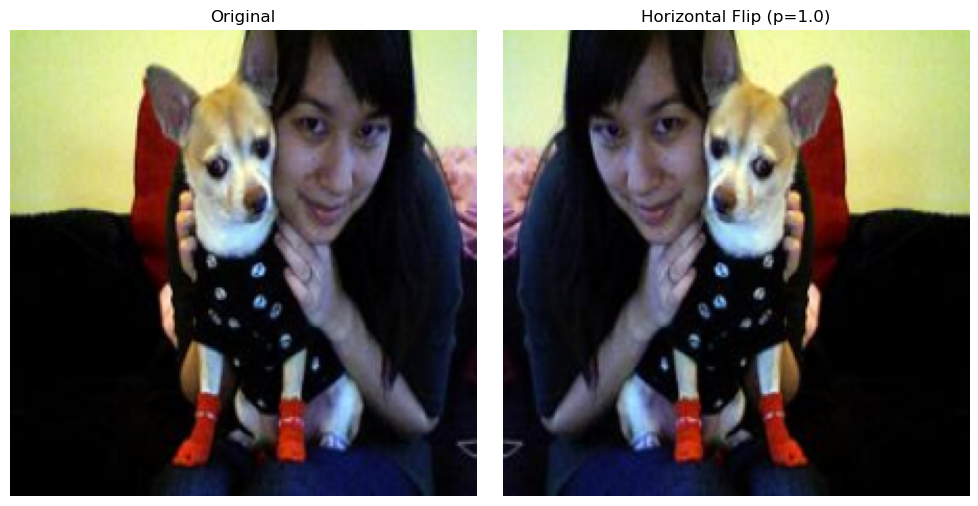

In [60]:
image_path = "data/stanford_dogs/Images/n02085620-Chihuahua/n02085620_7.jpg"

flipped = random_horizontal_flip(original_resized, p=1.0) 

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_resized)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(flipped)
plt.title("Horizontal Flip (p=1.0)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [51]:
def random_vertical_flip(image, p=0.5):
    """Flip image vertically with probability p"""
    if random.random() < p:
        return cv2.flip(image, 0)  # 0 means vertical flip
    return image


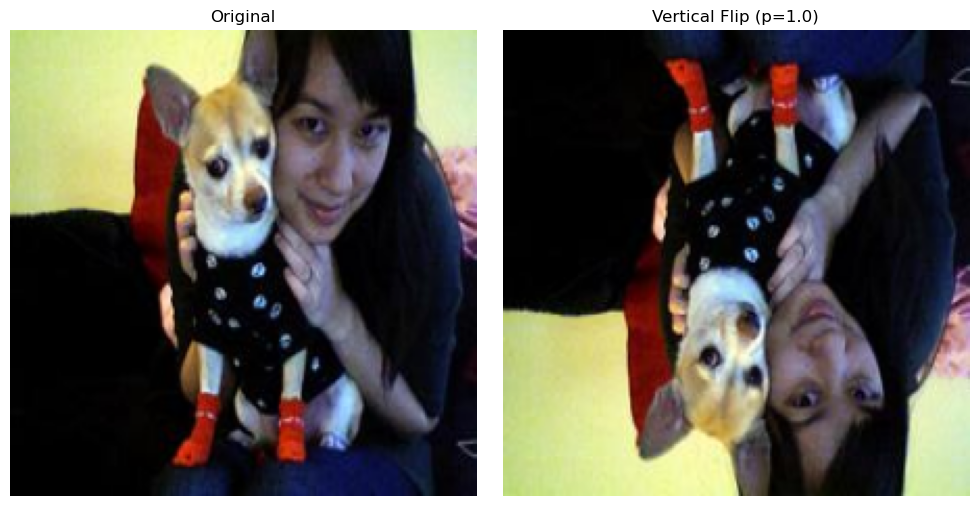

In [58]:
vflipped = random_vertical_flip(original_resized, p=1.0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_resized)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(vflipped)
plt.title("Vertical Flip (p=1.0)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [52]:
def random_rotation(image, degrees=15):
    """Rotate image by a random angle within ±degrees"""
    angle = random.uniform(-degrees, degrees)
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)


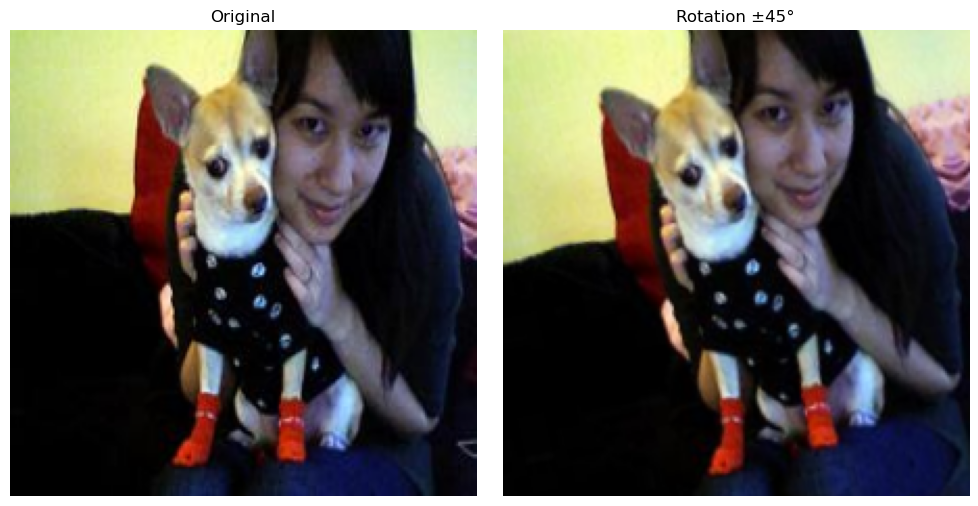

In [57]:
rotated = random_rotation(original_resized, degrees=45)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_resized)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rotated)
plt.title("Rotation ±45°")
plt.axis("off")

plt.tight_layout()
plt.show()

In [53]:

def random_affine(image, degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10):
    """Apply affine transformation: rotate, translate, scale, shear"""
    angle = random.uniform(-degrees, degrees)
    tx = random.uniform(-translate[0], translate[0]) * image.shape[1]
    ty = random.uniform(-translate[1], translate[1]) * image.shape[0]
    sx = random.uniform(scale[0], scale[1])
    sy = random.uniform(scale[0], scale[1])
    shear_x = np.deg2rad(random.uniform(-shear, shear))
    shear_y = np.deg2rad(random.uniform(-shear, shear))

    h, w = image.shape[:2]
    center = np.array([w / 2, h / 2])
    
    # Rotation matrix
    M = cv2.getRotationMatrix2D(tuple(center), angle, 1.0)

    # Translation
    M[:, 2] += (tx, ty)

    # Shear and scale
    shear_matrix = np.array([
        [sx, np.tan(shear_x), 0],
        [np.tan(shear_y), sy, 0]
    ], dtype=np.float32)

    M = shear_matrix @ np.vstack([M, [0, 0, 1]])  # Compose transforms
    M = M[:2, :]  # WarpAffine needs 2x3

    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

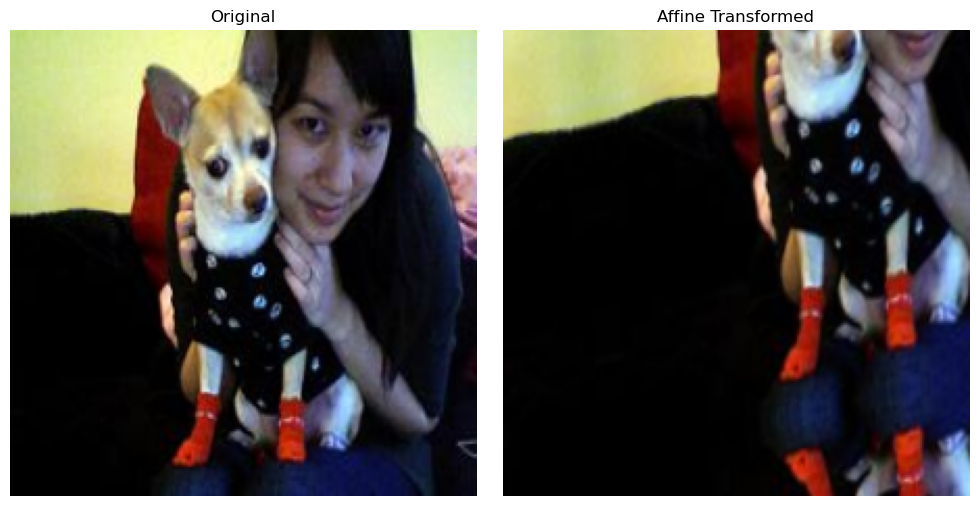

In [61]:

affined = random_affine(original_resized, degrees=30, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=20)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_resized)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(affined)
plt.title("Affine Transformed")
plt.axis("off")

plt.tight_layout()
plt.show()

In [54]:
def random_resized_crop(image, size=(224, 224), scale=(0.8, 1.0), ratio=(3./4., 4./3.)):
    """Random crop with resize. Similar to torchvision.transforms.RandomResizedCrop"""
    h, w = image.shape[:2]
    area = h * w

    for _ in range(10):  # Try 10 times to find a valid crop
        target_area = random.uniform(*scale) * area
        aspect_ratio = random.uniform(*ratio)

        new_w = int(round(np.sqrt(target_area * aspect_ratio)))
        new_h = int(round(np.sqrt(target_area / aspect_ratio)))

        if new_w <= w and new_h <= h:
            x1 = random.randint(0, w - new_w)
            y1 = random.randint(0, h - new_h)
            crop = image[y1:y1 + new_h, x1:x1 + new_w]
            return cv2.resize(crop, size, interpolation=cv2.INTER_AREA)

    # Fallback
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

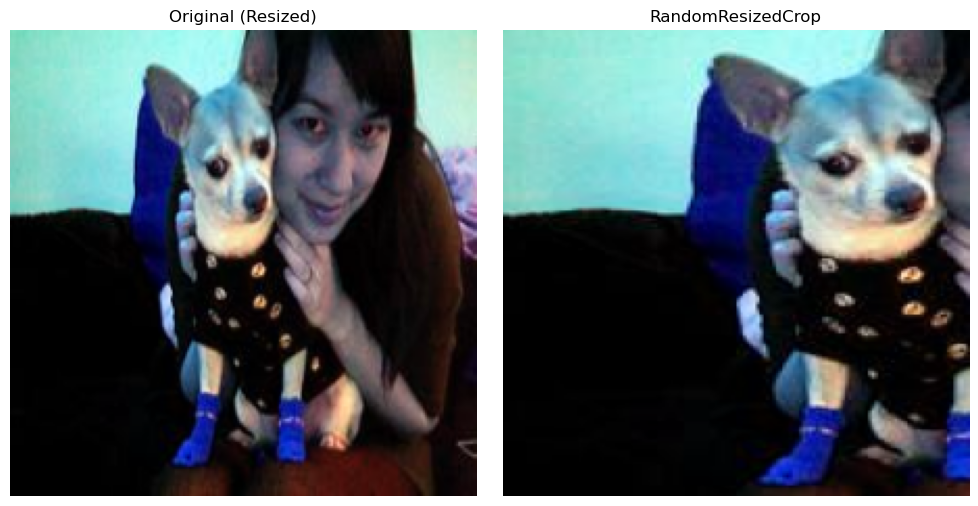

In [62]:
cropped = random_resized_crop(original, size=(224, 224), scale=(0.5, 0.7), ratio=(0.5, 1.5))

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.resize(cv2.cvtColor(original, cv2.COLOR_BGR2RGB), (224, 224)))
plt.title("Original (Resized)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.title("RandomResizedCrop")
plt.axis("off")

plt.tight_layout()
plt.show()

In [55]:
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# for path, label in tqdm(zip(image_paths, labels), total=len(image_paths)):
#     image = cv2.imread(path)
#     if image is None:
#         continue
    
#      image = resize_image(image)
#      image = normalize_image(image)
#      image = preprocess_image(image)
    
#     save_path = os.path.join(OUTPUT_DIR, label)
#     os.makedirs(save_path, exist_ok=True)
#     filename = os.path.basename(path)
    
#     save_img = (np.clip(image, 0, 1) * 255).astype(np.uint8)
#     cv2.imwrite(os.path.join(save_path, filename), save_img)
if __name__ == "__main__":
    image_paths, labels = load_dataset(DATA_DIR)
    print(f"Found {len(image_paths)} images")

    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Split the ratios:these are the ratios used for 
    # how much each dataset
    SPLIT_RATIOS = {
        "train": 0.7,
        "validation": 0.15,
        "test": 0.15
    }

    # Group paths by class, this ensures that each data split of train test and validation
    # contains examples of all breeds
    class_to_paths = {}
    
    for path, label in zip(image_paths, labels):
        if label not in class_to_paths:
           class_to_paths[label] = [] 
        class_to_paths[label].append(path)

    # assign each path to a split
    path_to_split = {}
    for label, paths in class_to_paths.items(): #for each dogbreed, get all its images
        # randomize the images going into each one by shuffling
        random.shuffle(paths)
        total = len(paths)
        train_end = int(SPLIT_RATIOS["train"] * total)
        val_end = train_end + int(SPLIT_RATIOS["validation"] * total)

        for i, path in enumerate(paths):
            if i < train_end:
                path_to_split[path] = "train"
            elif i < val_end:
                path_to_split[path] = "validation"
            else: #not in train or validation
                path_to_split[path] = "test"
                  

    # Create folders to sepearate train,test,validation data
    for split in SPLIT_RATIOS.keys():
        for label in class_to_paths:
            os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)            

    for path, label in tqdm(zip(image_paths, labels), total=len(image_paths),
                            desc="Preprocessing"):
        img = preprocess_image(path)
        if img is None:
            print(f"[READ FAIL] {path}")  # Warn if the image could not be read
            continue

        # Convert back to 0–255 and RGB→BGR before saving
        save_img = (img * 255).astype(np.uint8)
        save_img = cv2.cvtColor(save_img, cv2.COLOR_RGB2BGR)

        split = path_to_split.get(path, "train")
        save_dir = os.path.join(OUTPUT_DIR, split, label)
        os.makedirs(save_dir, exist_ok=True)

        cv2.imwrite(os.path.join(save_dir, os.path.basename(path)), save_img)

Found 20580 images


Preprocessing: 100%|██████████| 20580/20580 [00:54<00:00, 374.31it/s]
